Single qubit errors
===============

This is a simulation of single qubit errors in Qiskit to verify the depolarising and measurement noise model.  

In the depolarising error channel in Qiskit the parameter p implies a probability p that a qubit changes to a completely mixed state.  When the qubit is measured then with probability p/2 it will no longer be in the ground state.  
This was checked by applying the noise model to sequential X, Y, Z, H, S and SDG gates, measuring the result, and comparing with a calculation. 

This is part of an MSc project on the Steane code.  Please see https://goldsmdn.github.io/ for full details.

Import the necessary function modules.

In [1]:
from qiskit import(
  QuantumCircuit,
  QuantumRegister,
  ClassicalRegister,
  execute,
  Aer)

from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error

from helper_functions import get_noise, mean_of_list, calculate_standard_error

Define constants so the process flow can be controlled from one place:

In [2]:
SINGLE_GATE_SET = ['s','sdg','h','x','y','z']
TWO_GATE_SET = ['cx', 'cz']                    #Two gates not relevant
SHOTS = 10000                                  #Number of shots to run 
MEASURE_NOISE = 0.0046                         #Measurement noise
SINGLE_GATE_DEPOLARISING = 0.000366            #Single gate depolarising.   
TWO_GATE_DEPOLARISING = 0                      #Not relevant
NOISE = True                                   #Test with noise
GATE_DEPTH = 8                                 #Gate depth
LIST_GATE_TYPES = SINGLE_GATE_SET              #List of gates that is iterated over 
ITERATIONS = 25                                
#Number of iterations.  Note will take several minutes to run with 25 iterations.


SIMULATOR = Aer.get_backend('qasm_simulator')

The expected number of measurements in the ground state is estimated, recalling that with probabilily SINGLE_GATE_DEPOLARISING / 2 the gate will no longer be in the ground state. 

In [3]:
expected = ((1 - SINGLE_GATE_DEPOLARISING /2 ) ** GATE_DEPTH) * (1 - MEASURE_NOISE)

For each gate type we find the error.

In [4]:
print(f'We expect the |0> ground state with probability {expected:.4f}.')
print(f'There were {ITERATIONS} iterations.')
print()

for qubit_type in LIST_GATE_TYPES:
    ground_state_list = []
    for iteration in range(ITERATIONS):
        qr = QuantumRegister(1,'code_qubit')     # One qubit
        cr = ClassicalRegister(1,'syndrome_bit') # One Syndrome bit
        qc = QuantumCircuit(qr,cr)
        for i in range(GATE_DEPTH):
        # set up the circuit
            if qubit_type == 'x':
                qc.x(qr[0])
            elif qubit_type == 'y':
                qc.y(qr[0])
            elif qubit_type == 'z':  
                qc.z(qr[0])
            elif qubit_type == 'h': 
                qc.h(qr[0])
            elif qubit_type == 's':  
                qc.s(qr[0])
            elif qubit_type == 'sdg': 
                qc.sdg(qr[0])
            else:
                raise Exception("Unexpected qubit type in list")
        qc.measure(qr, cr)

        #initialise circuit
        noise_model = get_noise(MEASURE_NOISE, SINGLE_GATE_DEPOLARISING, TWO_GATE_DEPOLARISING,
                               SINGLE_GATE_SET, TWO_GATE_SET)
        if NOISE:
            result = execute(qc, SIMULATOR, noise_model=noise_model, shots=SHOTS).result()
        else:
            result = execute(qc, SIMULATOR, shots=SHOTS).result()     
        counts = result.get_counts(qc)
        ground_state = counts['0'] / SHOTS
        ground_state_list.append(ground_state)
    standard_deviation, standard_error = calculate_standard_error(ground_state_list)
    mean = mean_of_list(ground_state_list)
    print(f'For the {qubit_type} gate')
    print(f'  The mean is {mean:.4f}') 
    print(f'  The standard deviation is {standard_deviation:.4f} and the standard error is {standard_error:.4f}')

We expect the |0> ground state with probability 0.9939.
There were 25 iterations.

For the s gate
  The mean is 0.9940
  The standard deviation is 0.0007 and the standard error is 0.0001
For the sdg gate
  The mean is 0.9939
  The standard deviation is 0.0007 and the standard error is 0.0001
For the h gate
  The mean is 0.9939
  The standard deviation is 0.0006 and the standard error is 0.0001
For the x gate
  The mean is 0.9937
  The standard deviation is 0.0009 and the standard error is 0.0002
For the y gate
  The mean is 0.9939
  The standard deviation is 0.0009 and the standard error is 0.0002
For the z gate
  The mean is 0.9940
  The standard deviation is 0.0006 and the standard error is 0.0001


 An example circuit is shown below.

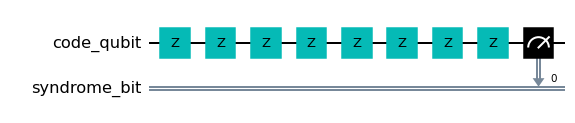

In [5]:
qc.draw(output='mpl', filename = 'Basic_single_qubit_error_circuit.jpg', fold=60)